In [ ]:


import requests
import zipfile
import io
import os

def download_and_extract_images(url, extract_path):
  """Downloads a zip file from a URL and extracts its contents.

  Args:
    url: The URL of the zip file.
    extract_path: The directory to extract the zip file contents to.
  """
  try:
    response = requests.get(url, stream=True)
    response.raise_for_status()  # Raise an exception for bad status codes

    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
      zip_ref.extractall(extract_path)
      print(f"Files extracted to {extract_path}")
  except requests.exceptions.RequestException as e:
      print(f"Error downloading file: {e}")
  except zipfile.BadZipFile as e:
      print(f"Error extracting file: {e}")
  except Exception as e:
      print(f"An unexpected error occurred: {e}")


# Example usage:
zip_file_url = "https://drive.google.com/uc?export=download&id=1Mj0jz9i9QTnC_dJK4DbMYZZWFxF0iv-h"  # Replace with the actual URL of your zip file
extraction_directory = "mapas"  # Replace with your desired directory

# Ensure the output directory exists
os.makedirs(extraction_directory, exist_ok=True)

download_and_extract_images(zip_file_url, extraction_directory)


Files extracted to mapas


Processing: mapas/Girardot.png


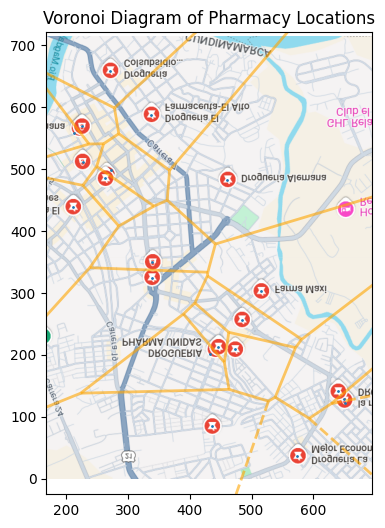

Processing: mapas/Bogota santaisabel.png


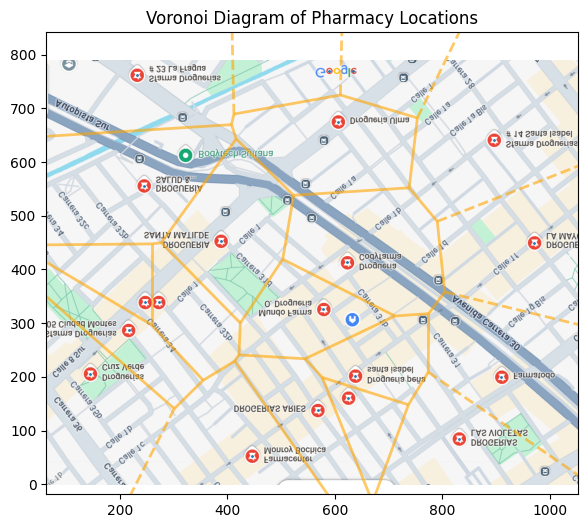

Processing: mapas/AguadeDios.png


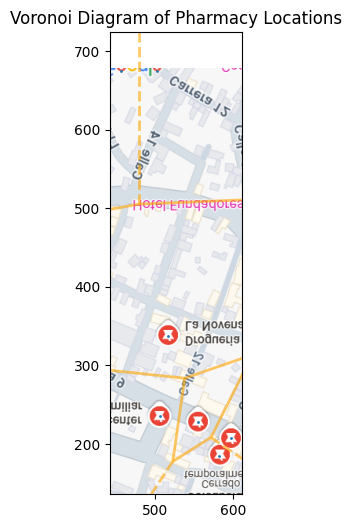

In [ ]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

def find_missing_pharmacy_zones(image_path):
    """
    Identifies potential missing pharmacy zones using Voronoi diagrams.

    Args:
    image_path: Path to the image of the city map.
    """
    try:
        # Load the image
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Could not open or read image {image_path}")
            return

        # Convert to HSV color space
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        # Define the lower and upper bounds for red color
        lower_red = np.array([0, 100, 100])
        upper_red = np.array([10, 255, 255])

        # Threshold the image to get only red pixels (pharmacies)
        mask = cv2.inRange(hsv, lower_red, upper_red)

        # Find contours of the red regions
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Extract coordinates of pharmacies
        pharmacy_coords = []
        for contour in contours:
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])

                # Verifica si las coordenadas están dentro de los límites de la imagen
                img_height, img_width, _ = img.shape
                if 0 <= cX < img_width and 0 <= cY < img_height:
                    pharmacy_coords.append((cX, cY))
                else:
                    print(f"Coordenadas fuera de los límites de la imagen: ({cX}, {cY})")  # Mensaje opcional para depuración

                # If no pharmacies are found, return.
                if not pharmacy_coords:
                    print("No pharmacies detected in the image.")
                    return

        # Generate Voronoi diagram
        vor = Voronoi(pharmacy_coords)

        # Plot the Voronoi diagram and image.
        fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='orange', line_width=2, line_alpha=0.6, point_size=2)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Show the image in the plot
        plt.title('Diagrama de Voronoi de Farmacias')
        fig.set_size_inches(10, 6)
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage (assuming the images are in the 'mapas' directory):
import glob
for filename in glob.glob('mapas/*.png'):  # Or any other image format
    print(f"Processing: {filename}")
    find_missing_pharmacy_zones(filename)
